In [1]:
!pip install opencv-contrib-python --upgrade

In [2]:
import os
import cv2
import dlib
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# tạo file kaggle.json
import json

data = {
    "username": "camhuy",   # đúng với username trên Kaggle
    "key": "KGAT_fd3cdad8ef19be80b840a5e6bdfdc3b5"  # dán API token vào đây
}

with open("kaggle.json", "w") as f:
    json.dump(data, f)

print("Đã tạo file kaggle.json!")

Đã tạo file kaggle.json!


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Tải dataset CelebA từ Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/celeba/
!unzip -q /content/celeba/celeba-dataset.zip -d /content/celeba/

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.31G/1.33G [00:10<00:00, 38.7MB/s]
100% 1.33G/1.33G [00:10<00:00, 136MB/s] 


In [6]:
# Tải thêm file identity_CelebA.txt để gom ảnh theo ID
## Cách 1: upload file từ local
# from google.colab import files
# uploaded = files.upload()
## Di chuyển vào thư mục dataset
# !mv /content/identity_CelebA.txt /content/celeba/

## Cách 2: down trực tiếp trên kaggle
!kaggle datasets download -d kymo9890/identity-celeba -p /content/celeba/
!unzip -q /content/celeba/identity-celeba.zip -d /content/celeba/

Dataset URL: https://www.kaggle.com/datasets/kymo9890/identity-celeba
License(s): unknown
  0% 0.00/943k [00:00<?, ?B/s]
100% 943k/943k [00:00<00:00, 734MB/s]


KIỂM TRA MÔI TRƯỜNG

In [7]:
import cv2
import numpy as np
import os
import random
from collections import defaultdict
from tqdm import tqdm

print("OpenCV version:", cv2.__version__)
assert hasattr(cv2.face, "LBPHFaceRecognizer_create"), "❌ OpenCV không có LBPH"

OpenCV version: 4.12.0


CONFIG

In [8]:
# ĐƯỜNG DẪN CELEBA
IMG_DIR = "/content/celeba/img_align_celeba/img_align_celeba"
IDENTITY_FILE = "/content/celeba/identity_CelebA.txt"

# DATASET LBPH
DATASET_DIR = "/content/celeba/lbph_dataset"

IMG_SIZE = (128, 128)

MAX_IDENTITY = 40
TRAIN_PER_ID = 8
VAL_PER_ID   = 2
TEST_PER_ID  = 2

random.seed(42)

LOAD IDENTITY CELEBA

In [9]:
person_images = defaultdict(list)

with open(IDENTITY_FILE, "r") as f:
    for line in f:
        img, pid = line.strip().split()
        person_images[int(pid)].append(img)

print("Total identities:", len(person_images))


Total identities: 10177


CHỌN IDENTITY PHÙ HỢP LBPH

In [10]:
import shutil

os.makedirs(DATASET_DIR, exist_ok=True)

valid_pids = [
    pid for pid, imgs in person_images.items()
    if len(imgs) >= (TRAIN_PER_ID + VAL_PER_ID + TEST_PER_ID)
]

random.shuffle(valid_pids)
selected_pids = valid_pids[:MAX_IDENTITY]

print("Selected identities:", len(selected_pids))


Selected identities: 40


BUILD DATASET

In [11]:
def save_img(pid, img_name, split):
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, IMG_SIZE)
    gray = cv2.equalizeHist(gray)

    save_dir = os.path.join(DATASET_DIR, split, str(pid))
    os.makedirs(save_dir, exist_ok=True)

    cv2.imwrite(os.path.join(save_dir, img_name), gray)

for pid in tqdm(selected_pids, desc="Building LBPH dataset"):
    imgs = person_images[pid]
    random.shuffle(imgs)

    for img in imgs[:TRAIN_PER_ID]:
        save_img(pid, img, "train")

    for img in imgs[TRAIN_PER_ID:TRAIN_PER_ID+VAL_PER_ID]:
        save_img(pid, img, "val")

    for img in imgs[TRAIN_PER_ID+VAL_PER_ID:
                    TRAIN_PER_ID+VAL_PER_ID+TEST_PER_ID]:
        save_img(pid, img, "test")

print("✅ Dataset ready")

Building LBPH dataset: 100%|██████████| 40/40 [00:00<00:00, 86.16it/s]

✅ Dataset ready


LOAD DATA (NO HAAR)

In [12]:
def load_data_no_haar(root_dir):
    faces = []
    labels = []

    label_map = {}
    current_label = 0

    for person_id in sorted(os.listdir(root_dir)):
        person_dir = os.path.join(root_dir, person_id)
        if not os.path.isdir(person_dir):
            continue

        label_map[current_label] = person_id

        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            faces.append(img)
            labels.append(current_label)

        current_label += 1

    return faces, np.array(labels), label_map


LOAD TRAIN / VAL / TEST

In [13]:
train_faces, train_labels, label_map = load_data_no_haar(
    os.path.join(DATASET_DIR, "train")
)
val_faces, val_labels, _ = load_data_no_haar(
    os.path.join(DATASET_DIR, "val")
)
test_faces, test_labels, _ = load_data_no_haar(
    os.path.join(DATASET_DIR, "test")
)

print("Train:", len(train_faces))
print("Val  :", len(val_faces))
print("Test :", len(test_faces))
print("Classes:", len(set(train_labels)))


Train: 320
Val  : 80
Test : 80
Classes: 40


TRAIN LBPH

In [14]:
model = cv2.face.LBPHFaceRecognizer_create(
    radius=2,
    neighbors=16,
    grid_x=8,
    grid_y=8
)

model.train(train_faces, train_labels)
model.save("lbph_celeba.yml")
print("✅ LBPH trained")

✅ LBPH trained


LẤY CONFIDENCE (RAW)

In [15]:
def get_confidences(model, faces, labels=None):
    confs, preds = [], []
    for img in faces:
        pred, conf = model.predict(img)
        confs.append(conf)
        preds.append(pred)
    return np.array(confs), preds


TỰ ĐỘNG TÌM THRESHOLD TỐI ƯU (VAL)

In [16]:
val_conf, val_pred = get_confidences(model, val_faces)

best_thr = None
best_score = -1

for thr in range(int(val_conf.min()), int(val_conf.max()), 2):
    correct = 0
    for pred, true, conf in zip(val_pred, val_labels, val_conf):
        if conf < thr and pred == true:
            correct += 1

    acc = correct / len(val_labels)

    if acc > best_score:
        best_score = acc
        best_thr = thr

print("✅ Best threshold:", best_thr)
print("✅ Best VAL accuracy:", best_score * 100)


✅ Best threshold: 179
✅ Best VAL accuracy: 40.0


CHUẨN HÓA CONFIDENCE (0–100)

In [17]:
CONF_MIN = val_conf.min()
CONF_MAX = val_conf.max()

def normalize_conf(conf):
    return 100 * (1 - (conf - CONF_MIN) / (CONF_MAX - CONF_MIN))


HISTOGRAM TRAIN / VAL / TEST

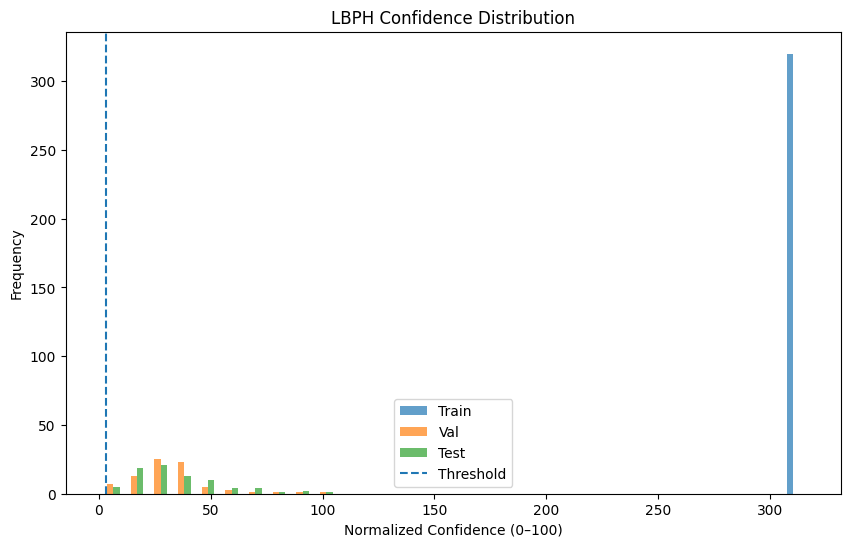

In [18]:
train_conf, _ = get_confidences(model, train_faces)
test_conf, _  = get_confidences(model, test_faces)

plt.figure(figsize=(10,6))
plt.hist([normalize_conf(train_conf),
          normalize_conf(val_conf),
          normalize_conf(test_conf)],
         bins=30,
         label=["Train", "Val", "Test"],
         alpha=0.7)

plt.axvline(
    normalize_conf(best_thr),
    linestyle="--",
    label="Threshold"
)

plt.xlabel("Normalized Confidence (0–100)")
plt.ylabel("Frequency")
plt.legend()
plt.title("LBPH Confidence Distribution")
plt.show()


FINAL TEST

In [19]:
correct = 0
rejected = 0

for img, true in zip(test_faces, test_labels):
    pred, conf = model.predict(img)
    if conf < best_thr:
        if pred == true:
            correct += 1
    else:
        rejected += 1

acc = correct / len(test_labels) * 100
rej = rejected / len(test_labels) * 100

print(f"🎯 TEST ACC: {acc:.2f}%")
print(f"🚫 TEST REJECT: {rej:.2f}%")


🎯 TEST ACC: 41.25%
🚫 TEST REJECT: 0.00%


TEST UNKNOWN

In [20]:
img = cv2.imread(
    "/content/celeba/img_align_celeba/img_align_celeba/000001.jpg",
    cv2.IMREAD_GRAYSCALE
)
img = cv2.resize(img, IMG_SIZE)
img = cv2.equalizeHist(img)

pred, conf = model.predict(img)
conf_norm = normalize_conf(conf)

if conf < best_thr:
    print("Known ID:", label_map[pred], "| conf =", conf_norm)
else:
    print("Unknown face | conf =", conf_norm)


Known ID: 8288 | conf = 23.621780466719745


In [21]:
import os
import cv2
import matplotlib.pyplot as plt

def display_lbph_predictions(
    model,
    test_dir,
    threshold,
    img_size=(128,128),
    max_images=20,
    cols=5
):
    images = []
    labels = []

    # Load test images
    for label in sorted(os.listdir(test_dir)):
        label_path = os.path.join(test_dir, label)
        if not os.path.isdir(label_path):
            continue

        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(int(label))

            if len(images) >= max_images:
                break
        if len(images) >= max_images:
            break

    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))

    for idx, (img, true_label) in enumerate(zip(images, labels)):
        pred, conf = model.predict(img)

        if conf < threshold:
            title = f"Pred: {pred}\nConf: {conf:.1f}"
        else:
            title = f"Unknown\nConf: {conf:.1f}"

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img, cmap="gray")
        plt.title(title, fontsize=9)
        plt.axis("off")

    plt.suptitle("LBPH Face Recognition – TEST RESULT", fontsize=14)
    plt.tight_layout()
    plt.show()


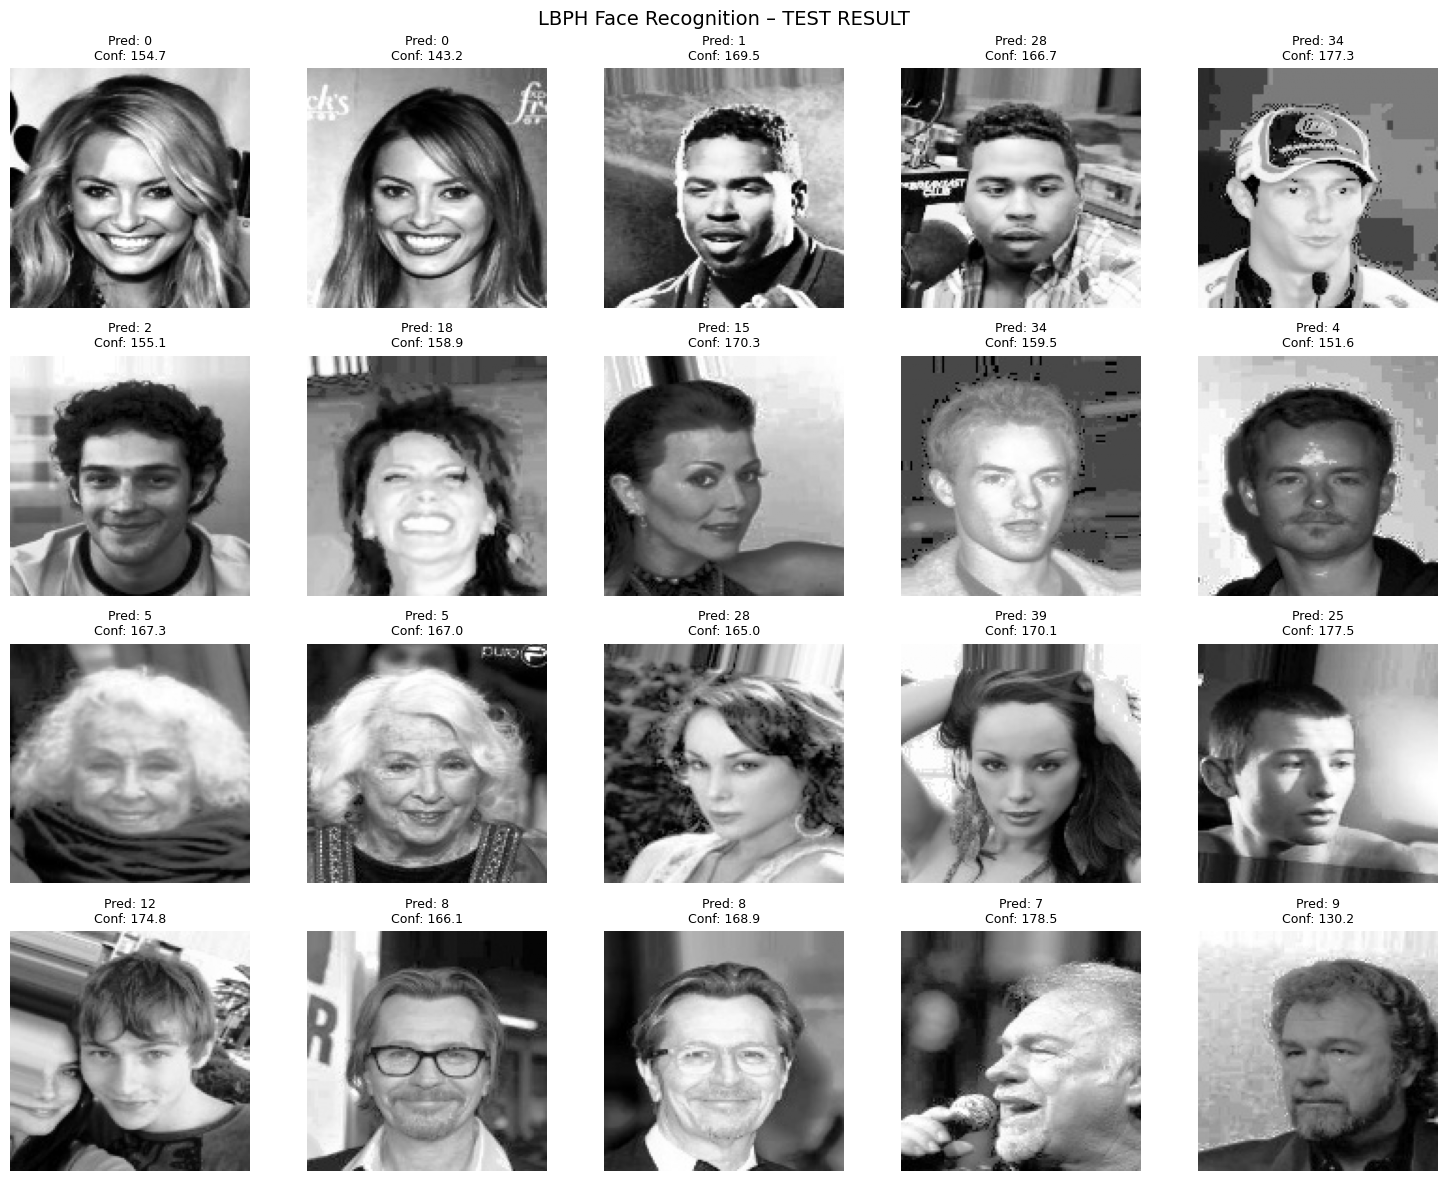

In [22]:
TEST_DIR = "/content/celeba/lbph_dataset/test"

display_lbph_predictions(
    model=model,
    test_dir=TEST_DIR,
    threshold=best_thr,   # threshold đã auto tìm
    max_images=20,
    cols=5
)


TẠO OUTPUT CHO MODEL

In [23]:
print("Model:", model)
print("Best threshold:", best_thr)


Model: < cv2.face.LBPHFaceRecognizer 0x7eb102e8f9d0>
Best threshold: 179


In [24]:
THRESH_PATH = "/content/lbph_threshold.txt"

with open(THRESH_PATH, "w") as f:
    f.write(str(best_thr))

print("✅ Saved threshold:", best_thr)


✅ Saved threshold: 179


In [25]:
import os
import json

TRAIN_DIR = "/content/celeba/lbph_dataset/train"
LABEL_MAP_PATH = "/content/label_map.json"

label_map = {}

for label in sorted(os.listdir(TRAIN_DIR)):
    if os.path.isdir(os.path.join(TRAIN_DIR, label)):
        label_map[int(label)] = f"person_{label}"

with open(LABEL_MAP_PATH, "w") as f:
    json.dump(label_map, f, indent=2)

print("✅ Saved label map with", len(label_map), "classes")


✅ Saved label map with 40 classes


In [26]:
import zipfile

MODEL_PATH = "/content/lbph_celeba.yml"
THRESH_PATH = "/content/lbph_threshold.txt"
LABEL_MAP_PATH = "/content/label_map.json"

ZIP_PATH = "/content/lbph_celeba_export.zip"

with zipfile.ZipFile(ZIP_PATH, "w") as zipf:
    zipf.write(MODEL_PATH, "lbph_celeba.yml")
    zipf.write(THRESH_PATH, "lbph_threshold.txt")
    zipf.write(LABEL_MAP_PATH, "label_map.json")

print("✅ Exported ZIP:", ZIP_PATH)


✅ Exported ZIP: /content/lbph_celeba_export.zip
